 # QLBS model for European Options
 
Part 1 of the notebook will hedge then price an option with a recursive dynamic programming solution (DP), an on-policy with risk aversion parameter.

Part 2 of the notebook will hedge then price an option with the same DP solution but with transaction costs added to the hedging process.

Part 3 will be on Fitted Q-Iteration (FQI) in a model-free, off policy setup to learn the optimal price and hedge directly from MC or historical data.

## We change the reward function to incorporate the standard deviation term instead of variance

## Part 1: QLBS DP approach (Known price-dynamics)
- Monte Carlo (MC) simulation of stock paths
- Computation of optimal hedge $a_t^\star(X_t)$ with minimum variance technique
- Backward recursively update and determine the optimal Q-function $Q_t^\star(X_t, a_t^\star)$ in basis functions with time-dependend coefficients


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import os

In [2]:
# User Inputs
# GLOBAL VARIABLES THAT DEFINE THE MODEL

## market dynamics
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.04      # risk-free rate

## option details
opt_type = 'Put'
M = 1         # maturity
K = 100       # option stike 
T = 24        # number of time steps
N_MC = 10000  # number of paths

## market dynamics
delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

np.random.seed(42)

## Monte Carlo Simulation

### Plotting functions

In [3]:
# Select 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size) # selected paths

def plot_tool(df, idx_plot, y_label, title, folder_name = 'graphs'):
    """
    Plots the optimal hedge and saves the plot in a specified folder.

    Parameters:
    - df: DataFrame of values to plot.
    - idx_plot: Index of the paths to plot.
    - y_label: Label for the y-axis.
    - title: Title of the plot.
    - folder_name: Name of the folder to save the plot.
    """
    plt.plot(df.T.iloc[:, idx_plot])
    plt.xlabel('Time Steps')
    plt.ylabel(y_label)
    plt.title(title)

    # Incorporating settings into subtitle
    plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type={}'.format(S0, mu, sigma, r, M, T, opt_type), fontsize=8, y=-0.01)
    
    # Create folder if it does not exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Save the plot in the specified folder
    plt.savefig(os.path.join(folder_name, '{}.png'.format(title)), dpi=300)
    plt.show()


## Initialization

In [4]:
def gen_stock_paths(S0, mu, sigma, T, N_MC, delta_t, r):
    """
    Simulates stock prices using Geometric Brownian Motion, computes adjusted stock returns,
    and calculates the log-processed state variable.

    Parameters:
    - S0: Initial stock price.
    - mu: Expected return.
    - sigma: Volatility of the stock.
    - T: Total time period.
    - N_MC: Number of Monte Carlo simulations.
    - delta_t: Time increment.
    - r: Risk-free interest rate.

    Returns:
    - S: DataFrame of simulated stock prices.
    - delta_S: DataFrame of stock returns.
    - delta_S_hat: DataFrame of adjusted stock returns.
    - X: DataFrame of log-processed state variables for each time step.
    - execution_time: Time taken to execute the simulation.
    """
    starttime = time.time()

    # Initialize empty DataFrame for stock prices
    S = pd.DataFrame([], index=range(1, N_MC + 1), columns=range(T + 1), dtype=float)
    S.loc[:, 0] = S0  # Set initial stock price for each simulation

    # Generate standard normal random variables
    RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC + 1), columns=range(1, T + 1))

    # Simulate stock price paths with Geometric Brownian Motion
    for t in range(1, T + 1):
        S.loc[:, t] = S.loc[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])

    # Calculate stock returns at each step
    delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]

    # Adjust stock returns by subtracting the mean return at each time step
    delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

    # Define the log-processed state variable for each time step
    X = - (mu - 0.5 * sigma**2) * np.tile(np.arange(T + 1) * delta_t, (N_MC, 1)) + np.log(S)

    endtime = time.time()
    execution_time = endtime - starttime

    print('\nExecution Time:', execution_time, 'seconds')

    return S, delta_S, delta_S_hat, X


In [5]:
# GLOBAL VARIABLES THAT DEFINE THE MODEL

S, delta_S, delta_S_hat, X = gen_stock_paths(S0, mu, sigma, T, N_MC, delta_t, r)


Execution Time: 0.08905863761901855 seconds


In [6]:
# S

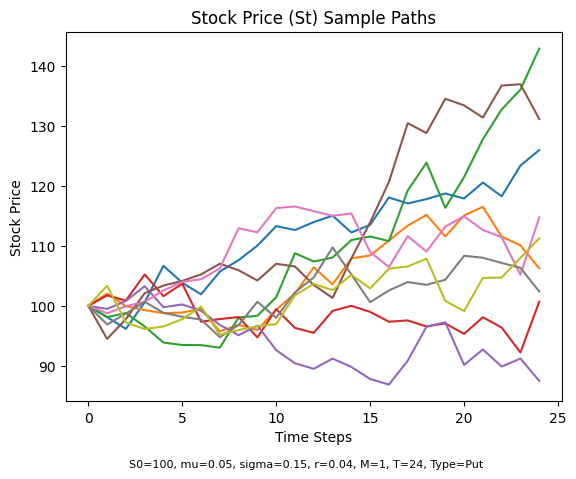

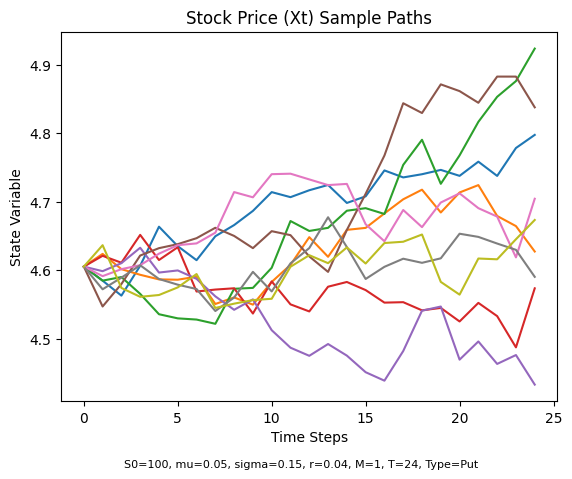

In [7]:
plot_tool(S, idx_plot, 'Stock Price', 'Stock Price (St) Sample Paths', folder_name = 'graphs')
plot_tool(X, idx_plot, 'State Variable', 'Stock Price (Xt) Sample Paths', folder_name = 'graphs')

### Payoff function

Define function *terminal_payoff* to compute the terminal payoff of a European option

Call: $$H_T\left(S_T\right)=\max\left(S_T-K,0\right)$$

Put: $$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [8]:
def terminal_payoff(ST, K, option_type):
    """
    Calculates the terminal payoff for call and put options.

    Parameters:
    - ST: Final stock price.
    - K: Strike price.
    - option_type: Type of the option ('call' or 'put').

    Returns:
    - The terminal payoff of the option.
    """
    if option_type.lower() == 'call':
        payoff = max(ST - K, 0)
    elif option_type.lower() == 'put':
        payoff = max(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return payoff

### Black-Scholes Formula

In [9]:
def bs_price(t, S0=S0, K=K, r=r, sigma=sigma, T=M, option_type=opt_type):
    """
    Calculates the Black-Scholes price for call and put options.

    Parameters:
    - option_type: Type of the option ('call' or 'put').
    - t: Current time.
    - S0: Initial stock price.
    - K: Strike price.
    - r: Risk-free interest rate.
    - sigma: Volatility of the underlying asset.
    - T: Time to maturity.

    Returns:
    - The Black-Scholes price of the option.
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)

    if option_type.lower() == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * (T - t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

##  Define spline basis functions  

Interpolate discretized problems to solve PDE using bspline to approximate the functions 

In [10]:
import bspline
import bspline.splinelab as splinelab


def gen_bspline_basis(X, p=4, ncolloc=12):
    """
    Generates a set of B-spline basis functions.

    Parameters:
    - X: State space DF used to define the range of the spline.
    - p: Order of the spline.
    - ncolloc: Number of collocation points/B-spline functions
    """
    X_min = np.min(X)
    X_max = np.max(X)
    print('X.shape = ', X.shape)
    print('X_min, X_max = ', X_min, X_max)

    tau = np.linspace(X_min, X_max, ncolloc)  # Interpolation sites

    # Generate the knot vector and create the spline basis
    k = splinelab.aptknt(tau, p)
    basis = bspline.Bspline(k, p)

    print('Number of points k = ', len(k))

    # Plotting
    f = plt.figure()
    basis.plot()

    # Ensure the save directory exists
    save_dir='basis_func_plots'
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save the figure with a filename that includes the number of basis functions
    filename = f'{save_dir}/Basis_functions_{ncolloc}.png'
    plt.savefig(filename, dpi=600)
    print(f'Plot saved to {filename}')

    # Optionally, close the plot if not needed to be shown interactively
    plt.close(f)
    
    return basis

X.shape =  (10000, 25)
X_min, X_max =  4.024923524903037 5.190802775129618
Number of points k =  17


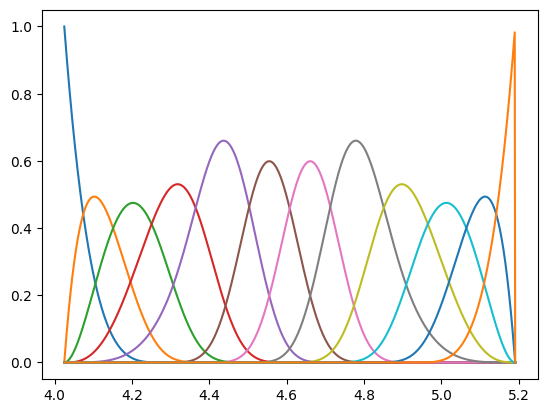

Plot saved to basis_func_plots/Basis_functions_12.png


<Figure size 640x480 with 0 Axes>

In [11]:
basis = gen_bspline_basis(X)

In [12]:
def apply_basis_funcs(X, basis, T, N_MC, num_basis=12):
    """
    Creates a data matrix filled with basis function values for each time step and simulation.

    Parameters:
    - X: The matrix of log-processed state variables.
    - basis: The bspline basis function.
    - num_t_steps: The number of time steps.
    - N_MC: The number of Monte Carlo simulations.
    - num_basis: The number of basis functions.

    Returns:
    - data_mat_t: A 3D numpy array containing the basis function values.
    """
    # Initialize the data matrix
    data_mat_t = np.zeros((T+1, N_MC, num_basis))
    print('num_basis =', num_basis)
    print('dimension of data_mat_t =', data_mat_t.shape)
    
    t_0 = time.time()
    # Fill the data matrix with basis function values
    for i in np.arange(T+1):
        x = X.values[:, i]  # Extract values for the current time step
        data_mat_t[i, :, :] = np.array([basis(el) for el in x])  # Apply data points onto bspline
    t_end = time.time()
    print('Computational time:', t_end - t_0, 'seconds')
    return data_mat_t

In [13]:
data_mat_t = apply_basis_funcs(X, basis, T, N_MC)

num_basis = 12
dimension of data_mat_t = (25, 10000, 12)
Computational time: 27.387614965438843 seconds


# QLBS model-based algorithm

In [34]:
risk_lambda = 0.001
epsilon = 0

## Compute hedge $a_t^\star$

Calculate coefficients  $\phi_{nt}$ of the optimal action $a_t^\star\left(X_t\right)$
- compute $A_{nm}^{\left(t\right)}$ matrix and $B_n^{\left(t\right)}$ column vector
- compute $$\phi_{nt}=\mathbf A_t^{-1}\mathbf B_t$$

Compute the optimal hedge $a_t^\star$ and portfolio value $\Pi_t$ backwardly

In [35]:
def compute_A_vec(t, delta_S_hat, data_mat, reg_param):
    """
    Calculate the A matrix for optimal hedging.

    Parameters:
    - t: Time index, an index into the time axis of data_mat.
    - delta_S_hat: DataFrame of adjusted stock price changes (N_MC x T).
    - data_mat: DataFrame of basis functions (T x N_MC x num_basis).
    - reg_param: Regularization parameter.

    Returns:
    - A matrix of dimension num_basis x num_basis.
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:, t]
    hat_dS2 = (this_dS ** 2).to_numpy().reshape(-1, 1) # flatten delta S df
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)

    return A_mat


def compute_B_vec(t, Pi_hat, delta_S_hat, data_mat, gamma, risk_lambda):
    """
    Compute the B vector used for optimal hedging.

    Parameters:
    - t: Time index, an index into the time axis of delta_S_hat.
    - Pi_hat: DataFrame of portfolio values (N_MC x T).
    - delta_S_hat: DataFrame of adjusted stock price changes (N_MC x T).
    - data_mat: DataFrame of basis functions (T x N_MC x num_basis).
    - gamma: One time-step discount factor exp(-r * delta_t).
    - risk_lambda: Risk aversion coefficient, a small positive number.

    Returns:
    - B vector of dimension num_basis x 1.
    """
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t]

    X_mat = data_mat[t, :, :]  # matrix of dimension N_MC x num_basis
    B_vec = np.dot(X_mat.T, tmp)

    return B_vec


In [36]:
def calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon=0):
    """
    Calculate the optimal hedge strategy and portfolio values.

    Parameters:
    - N_MC: Number of Monte Carlo simulations
    - T: Total time periods
    - S: DataFrame of simulated stock prices
    - delta_S: DataFrame of stock returns
    - delta_S_hat: DataFrame of adjusted stock returns
    - data_mat_t: DataFrame of basis functions
    - gamma: One time-step discount factor
    - risk_lambda: Risk aversion coefficient
    - epsilon: Transaction cost parameter (default is 0.01)

    Returns:
    - a: DataFrame of optimal hedge strategy
    - Pi: DataFrame of portfolio values
    - Pi_hat: DataFrame of adjusted portfolio values
    """
    starttime = time.time()

    # Initialize portfolio value
    Pi = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Pi.iloc[:, -1] = S.iloc[:, -1].apply(lambda x: terminal_payoff(x, K, opt_type))

    # Adjust portfolio value
    Pi_hat = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Pi_hat.iloc[:, -1] = Pi.iloc[:, -1] - np.mean(Pi.iloc[:, -1])

    # Initialize optimal hedge
    a = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    a.iloc[:, -1] = 0

    reg_param = 1e-3  # Free parameter for regularization
    
    for t in range(T - 1, -1, -1):
        A_mat = compute_A_vec(t, delta_S_hat, data_mat_t, reg_param)
        B_vec = compute_B_vec(t, Pi_hat, delta_S_hat, data_mat_t, gamma, risk_lambda)

        # Calculate coefficients for expansions of the optimal action
        phi = np.dot(np.linalg.inv(A_mat), B_vec)

        # Calculate optimal hedge
        a.loc[:, t] = np.dot(data_mat_t[t, :, :], phi)

        # With transaction cost adjustment
        Pi.loc[:, t] = gamma * (Pi.loc[:, t + 1] - a.loc[:, t] * delta_S.loc[:, t]) + epsilon * S.loc[:, t + 1] * abs(
            a.loc[:, t + 1] - a.loc[:, t])

        # Update adjusted portfolio value
        Pi_hat.loc[:, t] = Pi.loc[:, t] - np.mean(Pi.loc[:, t])

    # Convert data types to float
    a = a.astype('float')
    Pi = Pi.astype('float')
    Pi_hat = Pi_hat.astype('float')

    endtime = time.time()
    print('Computational time:', endtime - starttime, 'seconds')

    # Return results
    return a, Pi, Pi_hat


In [37]:
a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda)

Computational time: 0.7732088565826416 seconds


In [38]:
# a

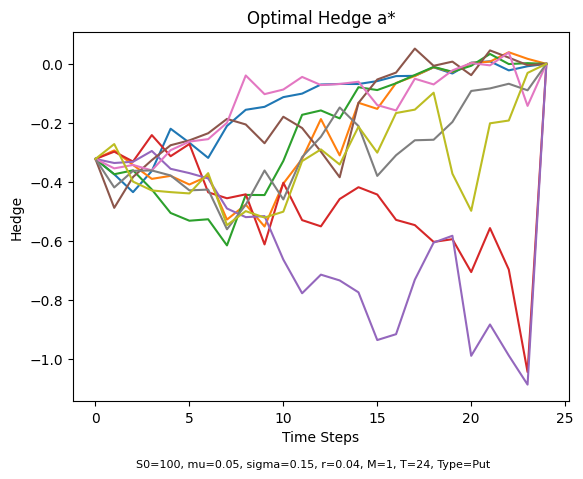

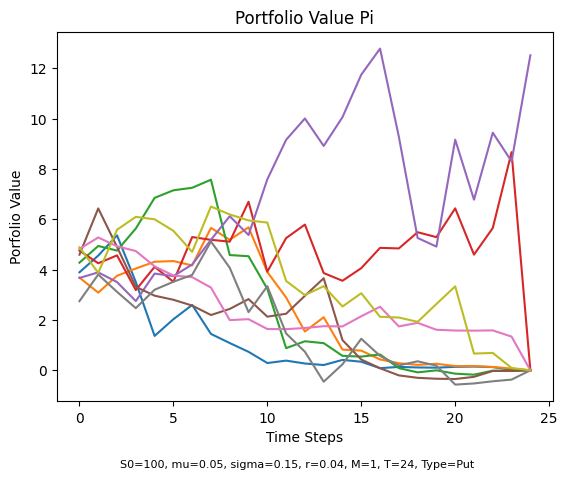

In [39]:
plot_tool(a, idx_plot, 'Hedge', 'Optimal Hedge a*')
plot_tool(Pi, idx_plot, 'Porfolio Value', 'Portfolio Value Pi')

## Compute reward function (MODIFIED)

Reward function $$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda \sqrt(Var\left[\Pi_t\space|\space\mathcal F_t\right])\quad t=0,...,T-1$$

We add on the stadard deviation $\sigma(\Pi_t)$

Use optimal hedge $a_t^\star$ and portfolio value $\Pi_t$  along with the terminal condition $R_T=-\lambda \sqrt(Var\left[\Pi_T\right])$ to calculate the rewards at each state backwardly

In [60]:
def compute_rewards(a, delta_S, Pi, gamma, risk_lambda):
    """
    Computes rewards for all paths based on the optimal hedge and portfolio values.
    NOTE: with std and a dminimishing factor (1-(t/T)) to break temporal symmetry

    Parameters:
    - a: DataFrame of optimal hedge values.
    - delta_S: DataFrame of adjusted stock returns.
    - Pi: DataFrame of portfolio values.
    - gamma: One time-step discount factor.
    - risk_lambda: Risk aversion coefficient.

    Returns:
    - R: DataFrame of computed rewards.
    """
    starttime = time.time()

    # Initialize DataFrame for rewards
    R = pd.DataFrame(index=a.index, columns=a.columns)

    # Compute rewards for each time step
    R.iloc[:, -1] = - risk_lambda * np.sqrt(np.var(Pi.iloc[:, -1]))

    for t in range(T):
        R.iloc[:, t] = (1-(t/T) ) * gamma * a.iloc[:, t] * delta_S.iloc[:, t] - risk_lambda * np.sqrt(np.var(Pi.iloc[:, t]))

    endtime = time.time()
    print('\nTime Cost:', endtime - starttime, 'seconds')

    return R


In [61]:
R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)


Time Cost: 0.044649362564086914 seconds


## Compute Q-function

Calculate coefficients $\omega_t$ of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$

- Compute $C_{nm}$ matrix and $D_n^{\left(t\right)}$ column vector
- Compute $$\omega_t=\mathbf C_t^{-1}\mathbf D_t$$

In [62]:
def compute_C_vec(t, data_mat, reg_param):
    """
    Parameters:
    - t: Time index, a scalar, an index into the time axis of data_mat.
    - data_mat: DataFrame of values of basis functions of dimension T x N_MC x num_basis.
    - reg_param: Regularization parameter, a scalar.

    Returns:
    - C_mat: np.array of dimension num_basis x num_basis.
    """
    X_mat = data_mat[t, :, :]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat
   
def compute_D_vec(t, Q, R, data_mat, gamma=gamma):
    """
    Parameters:
    - t: Time index, a scalar, an index into the time axis of data_mat.
    - Q: DataFrame of Q-function values of dimension N_MC x T.
    - R: DataFrame of rewards of dimension N_MC x T.
    - data_mat: DataFrame of values of basis functions of dimension T x N_MC x num_basis.
    - gamma: One time-step discount factor $exp(-r \delta t)$.

    Returns:
    - D_vec: np.array of dimension num_basis x 1.
    """
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:, t] + gamma * Q.loc[:, t + 1])
    return D_vec

compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$ backwardly with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=-\Pi_T\left(X_T\right)-\lambda \sqrt(Var\left[\Pi_T\left(X_T\right)\right])$.

In [63]:
def compute_Q_function(Pi, data_mat_t, risk_lambda):
    """
    Computes the Q-function values using regularization and matrix operations.

    Parameters:
    - Pi: DataFrame of portfolio values.
    - data_mat_t: DataFrame of values of basis functions.
    - risk_lambda: Risk aversion coefficient.

    Returns:
    - Q: DataFrame of Q-function values.
    """
    starttime = time.time()

    # Initialize DataFrame for Q-function values
    Q = pd.DataFrame([], index=range(1, N_MC + 1), columns=range(T + 1))
    # Terminal condition
    Q.iloc[:, -1] = - Pi.iloc[:, -1] - risk_lambda * np.sqrt(np.var(Pi.iloc[:, -1]))

    reg_param = 1e-3
    for t in range(T - 1, -1, -1):
        C_mat = compute_C_vec(t, data_mat_t, reg_param)
        D_vec = compute_D_vec(t, Q, R, data_mat_t, gamma)
        omega = np.dot(np.linalg.inv(C_mat), D_vec)
        
        Q.loc[:, t] = np.dot(data_mat_t[t, :, :], omega)
        
    Q = Q.astype('float')
    endtime = time.time()
    execution_time = endtime - starttime
    print('\nTime Cost:', execution_time, 'seconds')

    return Q



Time Cost: 0.4157869815826416 seconds


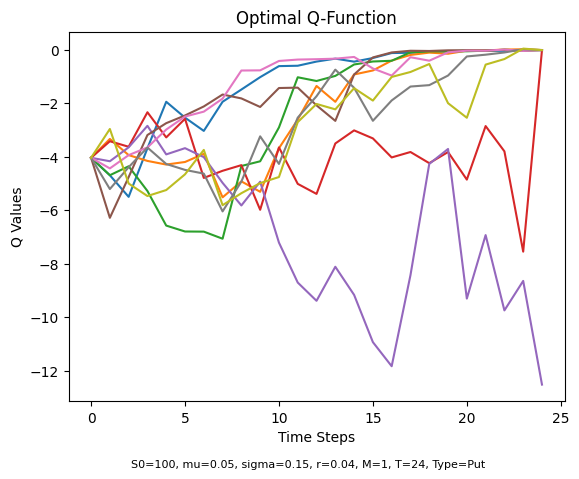

In [64]:
Q = compute_Q_function(Pi, data_mat_t, risk_lambda)
plot_tool(Q, idx_plot, 'Q Values', 'Optimal Q-Function')

In [65]:
# Q

-------------------------------------------
       QLBS Put Option Pricing (DP solution)      
-------------------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.04
Risk aversion parameter:  0.001
Trans Cost parameter:     0
Strike:                   100
Maturity:                 1

QLBS Put Price:           4.0364

Black-Sholes Put Price:   4.1075




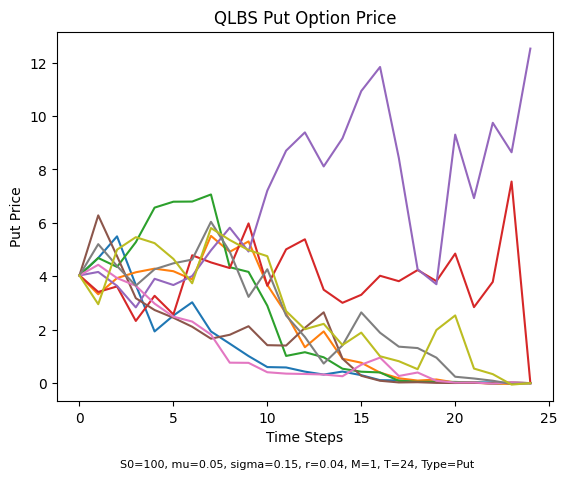

In [66]:
# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print(f'       QLBS {opt_type} Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Trans Cost parameter: '), epsilon)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
print('\n')

plot_tool(C_QLBS, idx_plot, 'Put Price', f'QLBS {opt_type} Option Price')

# Experiments

## QLBS optimal hedge a* against BSM delta 

In [27]:
# calculate black scholes delta

def black_scholes_delta(S, K, r, sigma, T, t, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * ((T - t)/T)) / (sigma * np.sqrt(T - t))
    if option_type.lower() == 'call':
        delta = norm.cdf(d1)
    elif option_type.lower() == 'put':
        delta = norm.cdf(d1) - 1
    return delta

t_values = np.arange(1, T+1)  # time steps

# Create DataFrame to store Black-Scholes deltas for put option
black_scholes_deltas_put = pd.DataFrame(index=range(1, N_MC+1), columns=t_values, dtype=float)

# Calculate Black-Scholes delta for each time step for each stock path for put option
for t in t_values:
    black_scholes_deltas_put[t] = black_scholes_delta(S.loc[:, t], K, r, sigma, T, t, opt_type)
    
# black_scholes_deltas_put

In [28]:
def plot_hedge_and_deltas(a, black_scholes_deltas_put, S, idx, S0, mu, sigma, r, M, T):
    # Create figure and first subplot for the hedge
    fig, ax1 = plt.subplots()

    # Plot the hedge on the first subplot
    hedge_plot, = ax1.plot(a.T.iloc[:, idx], color='blue', marker='o', linestyle='-', label='Optimal Hedge (a*)')
    bs_deltas_plot, = ax1.plot(black_scholes_deltas_put.T.iloc[:, idx], color='green', marker='x', linestyle='-', label='Black-Scholes Deltas (Put)')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Hedge', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title('Optimal Hedge a*')

    # Create a second subplot sharing the same x-axis with the first subplot
    ax2 = ax1.twinx()

    # Plot the stock price on the second subplot
    ax2.plot(S.T.iloc[:, idx], color='red')
    ax2.set_ylabel('Stock Price', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Incorporating settings into subtitle
    plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)

    # Add legend for the curves on axis 1
    plt.legend(handles=[hedge_plot, bs_deltas_plot], loc='upper right')

    plt.show()

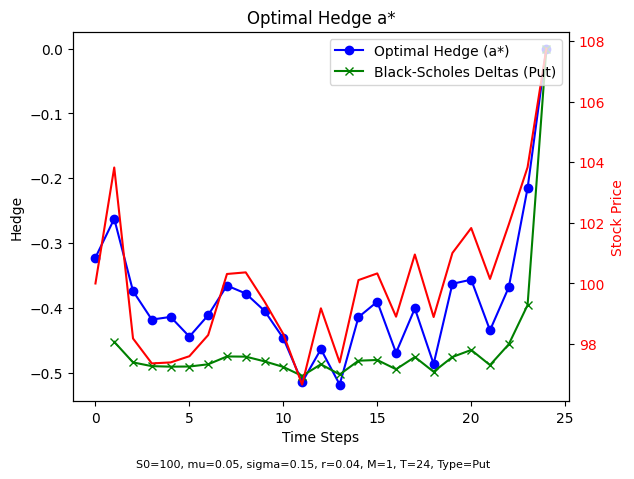

In [29]:
idx = 500
plot_hedge_and_deltas(a, black_scholes_deltas_put, S, idx, S0, mu, sigma, r, M, T)

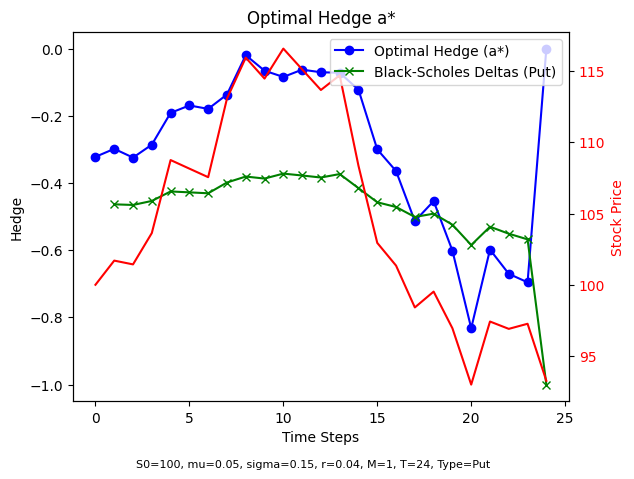

In [30]:
idx = 0
plot_hedge_and_deltas(a, black_scholes_deltas_put, S, idx, S0, mu, sigma, r, M, T)

## Delta Curve

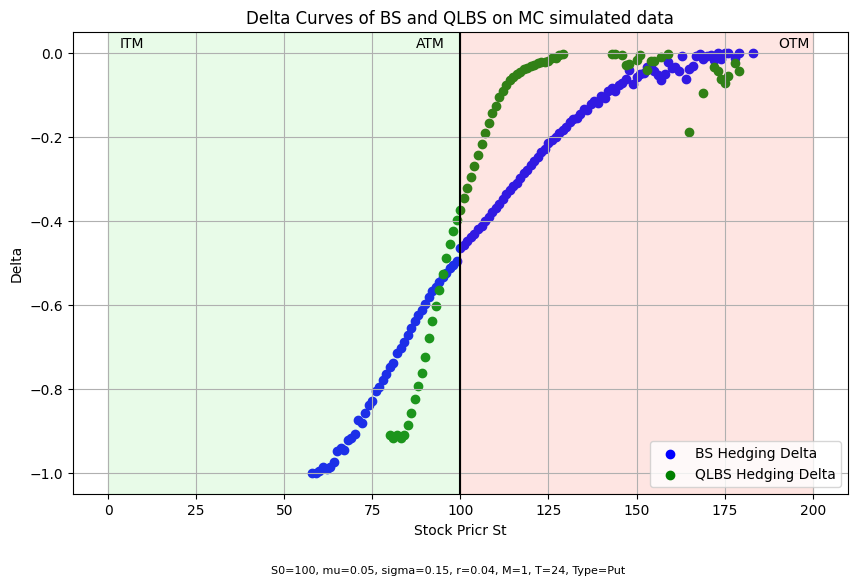

In [31]:
#### QLBS Delta
a_t = a.iloc[:, :-1]
S_t = S.iloc[:, 1:]

flattened_a = a_t.values.flatten()
flattened_S = S_t.values.flatten()

# Assuming flattened_S and flattened_a are 1D arrays
data = {'flattened_S': flattened_S, 'flattened_a': flattened_a}

# Create DataFrame
delta_curve = pd.DataFrame(data)
delta_curve = delta_curve.sort_values(by='flattened_S')

# Group the sorted DataFrame by values within 500 of each other and calculate the mean
grouped_mean = delta_curve.groupby(pd.cut(delta_curve['flattened_S'], bins=range(int(delta_curve['flattened_S'].min()), int(delta_curve['flattened_S'].max()) + 1, 1)))['flattened_a'].mean()

average_hedges = []

# Convert the grouped_mean Series to a DataFrame
grouped_mean_df = grouped_mean.reset_index()

grouped_mean_df = grouped_mean_df.iloc[22:]
grouped_mean_df = grouped_mean_df[grouped_mean_df['flattened_a'] <= 0]


# Display the DataFrame with mean values
# print(grouped_mean_df)
# x_values = grouped_mean_df['flattened_S'].apply(lambda x: x.left)
grouped_mean_df['flattened_S'] = grouped_mean_df['flattened_S'].apply(lambda x: x.left)
grouped_mean_df['flattened_S'] = grouped_mean_df['flattened_S'].astype(int)

# Extract the mean values
y_values = grouped_mean_df['flattened_a']

#### BS Delta

# flattened_S = S_t.values.flatten()    
flattened_bs_a = black_scholes_deltas_put.values.flatten()

# Assuming flattened_S and flattened_a are 1D arrays
data_bs = {'flattened_S': flattened_S, 'flattened_bs_a': flattened_bs_a}

# Create DataFrame
delta_curve_bs = pd.DataFrame(data_bs)
delta_curve_bs = delta_curve_bs.sort_values(by='flattened_S')

# Group the sorted DataFrame by values within 500 of each other and calculate the mean
grouped_mean_bs = delta_curve_bs.groupby(pd.cut(delta_curve_bs['flattened_S'], bins=range(int(delta_curve_bs['flattened_S'].min()), int(delta_curve_bs['flattened_S'].max()) + 1, 1)))['flattened_bs_a'].mean()

average_bs_hedges = []

# Convert the grouped_mean Series to a DataFrame
grouped_mean_bs_df = grouped_mean_bs.reset_index()


# Display the DataFrame with mean values
# print(grouped_mean_df)
x_values_bs = grouped_mean_bs_df['flattened_S'].apply(lambda x: x.left)

# Extract the mean values
y_values_bs = grouped_mean_bs_df['flattened_bs_a']

grouped_mean_bs_df['flattened_S'] = x_values_bs


# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first pair of scatter plots
ax.scatter(x_values_bs, y_values_bs, marker='o', color='b', label='BS Hedging Delta')

# Plot the second pair of scatter plots on the same axis
ax.scatter(grouped_mean_df['flattened_S'], y_values, marker='o', color='g', label='QLBS Hedging Delta')

# Set labels and title
ax.set_xlabel('Stock Pricr St')
ax.set_ylabel('Delta')
ax.set_title('Delta Curves of BS and QLBS on MC simulated data')
# Incorporating settings into subtitle
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type={}'.format(S0, mu, sigma, r, M, T, opt_type), fontsize=8, y=-0.01)

# Add a vertical line at 35000 in black
ax.axvline(x=K, color='k')

# # Add text annotations for OTM and ITM at top left and top right corners respectively
ax.text(0.06, 0.99, 'ITM', ha='left', va='top', transform=ax.transAxes)
ax.text(0.95, 0.99, 'OTM', ha='right', va='top', transform=ax.transAxes)
ax.text(0.48, 0.99, 'ATM', ha='right', va='top', transform=ax.transAxes)

# Shade the region to the left of the line with sky blue (OTM)
ax.axvspan(0, K, color='lightgreen', alpha=0.2)

# Shade the region to the right of the line with salmon pink (ITM)
ax.axvspan(K, 200, color='salmon', alpha=0.2)

# Show legend
ax.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()



## Portfolio PnL histogram

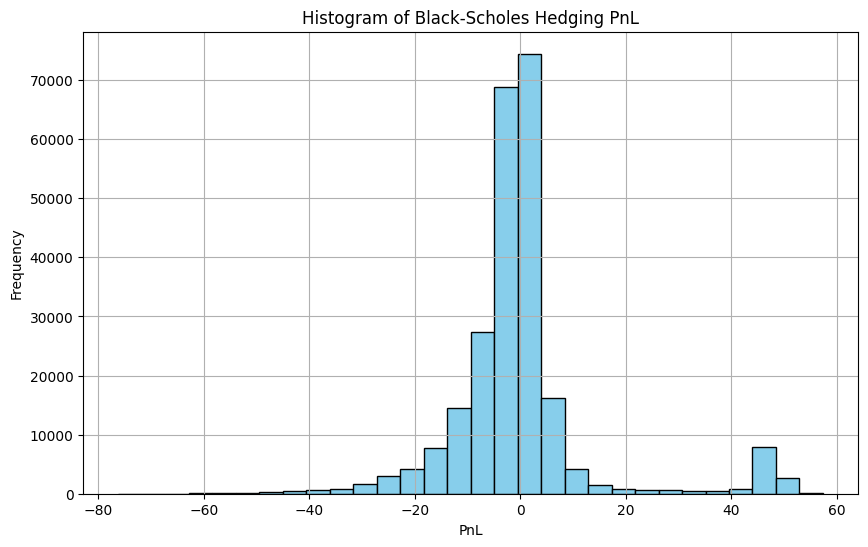

In [32]:
# Initialize an empty DataFrame to store PnL_BS for each cell
PnL_BS = pd.DataFrame(index=S.index, columns=S.columns)

# Calculate PnL_BS for each cell
for t in range(T):
    if t == 0:
        # For the first time step, PnL_BS is calculated using the initial Black-Scholes delta
        PnL_BS.iloc[:, t] = -black_scholes_deltas_put.iloc[:, t] * S.iloc[:, t]
    else:
        # For subsequent time steps, PnL_BS is calculated using the difference in Black-Scholes deltas
        delta_change = black_scholes_deltas_put.iloc[:, t] - black_scholes_deltas_put.iloc[:, t - 1]
        PnL_BS.iloc[:, t] = delta_change * S.iloc[:, t]

# Apply terminal payoff to each cell and subtract from PnL_BS
for t in range(T):
    payoff = S.applymap(lambda x: terminal_payoff(x, K, opt_type))
    PnL_BS.iloc[:, t] -= payoff.iloc[:, t]

# Flatten the PnL_BS DataFrame into a 1D array
pnl_bs_flat = PnL_BS.values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pnl_bs_flat, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.title('Histogram of Black-Scholes Hedging PnL')
plt.grid(True)
plt.show()



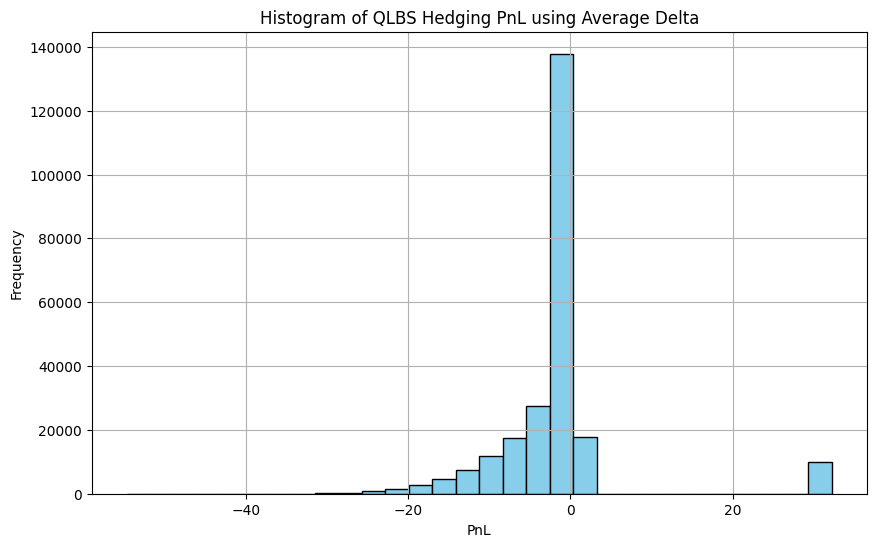

In [33]:
# Calculate the average delta for each time step
average_delta = a.mean()

# Initialize an empty DataFrame to store PnL_QLBS for each cell
PnL_QLBS = pd.DataFrame(index=S.index, columns=S.columns)

# Calculate PnL_QLBS for each cell
for t in range(T):
    if t == 0:
        # For the first time step, PnL_QLBS is calculated using the initial average delta
        PnL_QLBS.iloc[:, t] = -average_delta[t] * S.iloc[:, t]
    else:
        # For subsequent time steps, PnL_QLBS is calculated using the difference in deltas
        PnL_QLBS.iloc[:, t] = Pi.iloc[:, t] - Pi.iloc[:, t-1]

# Apply terminal payoff to each cell and subtract from PnL_QLBS
for t in range(T):
    payoff = S.applymap(lambda x: terminal_payoff(x, K, opt_type))
    PnL_QLBS.iloc[:, t] -= payoff.iloc[:, t]

# Flatten the PnL_QLBS DataFrame into a 1D array
pnl_qlbs_flat = PnL_QLBS.values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pnl_qlbs_flat, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.title('Histogram of QLBS Hedging PnL using Average Delta')
plt.grid(True)
plt.show()



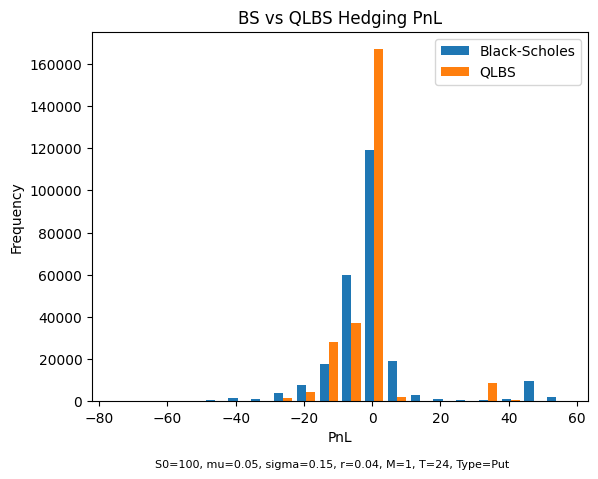

In [34]:
# Define the data series
pnl_bs_flat = np.array(pnl_bs_flat)
pnl_qlbs_flat = np.array(pnl_qlbs_flat)

# Plot histogram for both PnL series
plt.hist([pnl_bs_flat, pnl_qlbs_flat], bins=20, label=['Black-Scholes', 'QLBS'])
plt.legend(loc='upper right')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.title('BS vs QLBS Hedging PnL')
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.show()

### Statistical Test

In [64]:
pnl_bs_flat = pd.Series(pnl_bs_flat)
pnl_qlbs_flat = pd.Series(pnl_qlbs_flat)

mean_val = pnl_bs_flat.mean()
# Replace NaN values with the mean
pnl_bs_flat = pnl_bs_flat.fillna(mean_val)
print(f'BS PnL mean: {np.mean(pnl_bs_flat)}')

mean_val = pnl_qlbs_flat.mean()
# Replace NaN values with the mean
pnl_qlbs_flat = pnl_qlbs_flat.fillna(mean_val)
print(f'QLBS PnL mean: {np.nanmean(pnl_qlbs_flat)}')

BS PnL mean: -0.3871840737511551
QLBS PnL mean: -1.4873561916064524


In [68]:
from scipy import stats

**Null Hypothesis (H0):** There is no significant difference between the standard deviations of the two datasets (pnl_bs_flat and pnl_qlbs_flat). <br/>
**Alternative Hypothesis (H1):** There is a significant difference between the standard deviations of the two datasets.

In [71]:
# Perform F-test to compare standard deviations
f_statistic, p_value = stats.f_oneway(pnl_bs_flat, pnl_qlbs_flat)

# Display the results
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the standard deviations.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the standard deviations.")


F-statistic: 1238.4277372389095
P-value: 5.848133868132533e-271
Reject the null hypothesis: There is a significant difference between the standard deviations.



**Null Hypothesis (H0):** The mean of pnl_bs_flat is not larger than pnl_qlbs_flat.  <br/>
**Alternative Hypothesis (H1):** The mean of pnl_bs_flat is larger than pnl_qlbs_flat.  

If p-value < alpha (typically 0.05), reject the null hypothesis.



In [72]:
# Perform one-tailed t-test
t_statistic, p_value = stats.ttest_ind(pnl_bs_flat, pnl_qlbs_flat, alternative='greater')

# Define significance level
alpha = 0.05

# Check if the null hypothesis can be rejected
print("T-statistic:", f_statistic)
print("P-value:", p_value)
if p_value < alpha:
    print("Reject the null hypothesis (H0): The mean of pnl_bs_flat is statistically larger than pnl_qlbs_flat.")
else:
    print("Fail to reject the null hypothesis (H0): There is no sufficient evidence to conclude that the mean of pnl_bs_flat is larger than pnl_qlbs_flat.")

T-statistic: 1238.4277372389095
P-value: 2.9240669337257403e-271
Reject the null hypothesis (H0): The mean of pnl_bs_flat is statistically larger than pnl_qlbs_flat.


## Vary risk aversion

In [27]:
# Given S, delta_S, delta_S_hat, X, data_mat_t 

risk_lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01]  
qlbs_put_prices = []
add_premiums = []

for risk_lambda in risk_lambdas:
    a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda)
    R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)
    Q = compute_Q_function(Pi, data_mat_t, risk_lambda)
    
    # QLBS option price
    C_QLBS = - Q.copy()
    print('-------------------------------------------')
    print(f'Current risk aversion {risk_lambda}')
    print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
    qlbs_put_prices.append(C_QLBS.iloc[0,0])
    print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
    add_premium = (C_QLBS.iloc[0,0]-bs_price(0))/bs_price(0)
    add_premiums.append(add_premium)
    print(f'Additional premium % {add_premium * 100}')
    print('-------------------------------------------')

Computational time: 0.5039749145507812 seconds

Time Cost: 0.025828838348388672 seconds

Time Cost: 0.37159299850463867 seconds
-------------------------------------------
Current risk aversion 0.0001

QLBS Put Price:           4.0297

Black-Sholes Put Price:   4.1075
Additional premium % -1.8940456724742576
-------------------------------------------
Computational time: 0.43463706970214844 seconds

Time Cost: 0.025730133056640625 seconds

Time Cost: 0.3083798885345459 seconds
-------------------------------------------
Current risk aversion 0.0005

QLBS Put Price:           4.0705

Black-Sholes Put Price:   4.1075
Additional premium % -0.9007296523020194
-------------------------------------------
Computational time: 0.43155789375305176 seconds

Time Cost: 0.02530527114868164 seconds

Time Cost: 0.31693291664123535 seconds
-------------------------------------------
Current risk aversion 0.001

QLBS Put Price:           4.1215

Black-Sholes Put Price:   4.1075
Additional premium % 0.3

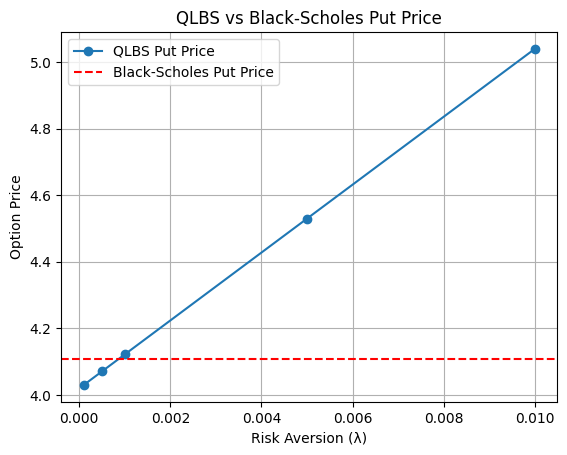

In [28]:
# Black-Scholes Put Price
bs_put_price = bs_price(0)

# Plot QLBS Put Prices
plt.plot(risk_lambdas, qlbs_put_prices, marker='o', label='QLBS Put Price')

# Plot Black-Scholes Put Price as a horizontal line
plt.axhline(y=bs_put_price, color='r', linestyle='--', label='Black-Scholes Put Price')

# Add labels and title
plt.xlabel('Risk Aversion (λ)')
plt.ylabel('Option Price')
plt.title('QLBS vs Black-Scholes Put Price')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Part 2: Transaction Costs

$\epsilon$ will denote proportional transaction costs in this setup. When running "calculate_optimal_hedge" we define the proportional transaction costs incurred for each hedging action. $\lambda$ is maintained at 0.001

In [29]:
risk_lambda = 0.001
epsilon = 0.01

# include transaction cost parameter epsilon
a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon)
R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)
Q = compute_Q_function(Pi, data_mat_t, risk_lambda)

# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print(f'       QLBS {opt_type} Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Trans Cost parameter: '), epsilon)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
print('\n')

Computational time: 0.4740889072418213 seconds

Time Cost: 0.02667999267578125 seconds

Time Cost: 0.3571600914001465 seconds
-------------------------------------------
       QLBS Put Option Pricing (DP solution)      
-------------------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.04
Risk aversion parameter:  0.001
Trans Cost parameter:     0.01
Strike:                   100
Maturity:                 1

QLBS Put Price:           4.1701

Black-Sholes Put Price:   4.1075




## Vary Transaction Costs

In [30]:
a_results = {0.001:[], 0.005:[], 0.01:[], 0.02:[]}
q_results = {0.001:[], 0.005:[], 0.01:[], 0.02:[]}

epsilons = [0.001, 0.005, 0.01, 0.02]

for epsilon in epsilons:
    a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon)
    R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)
    Q = compute_Q_function(Pi, data_mat_t, risk_lambda)
    
    # QLBS option price
    C_QLBS = - Q.copy()
    print('-------------------------------------------')
    print(f'Current Epsilon {epsilon} and risk aversion {risk_lambda}')
    print('%-26s %.4f' % (f'\nQLBS {opt_type} Price: ', C_QLBS.iloc[0,0]))
    print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
    print('-------------------------------------------')
    
    # append to results
    a_results[epsilon] = a.iloc[0]
    q_results[epsilon] = Q.iloc[0]

Computational time: 0.47913193702697754 seconds

Time Cost: 0.03191018104553223 seconds

Time Cost: 0.3626277446746826 seconds
-------------------------------------------
Current Epsilon 0.001 and risk aversion 0.001

QLBS Put Price:           4.1257

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computational time: 0.45164012908935547 seconds

Time Cost: 0.025865793228149414 seconds

Time Cost: 0.3163259029388428 seconds
-------------------------------------------
Current Epsilon 0.005 and risk aversion 0.001

QLBS Put Price:           4.1434

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computational time: 0.44024229049682617 seconds

Time Cost: 0.025534868240356445 seconds

Time Cost: 0.32616710662841797 seconds
-------------------------------------------
Current Epsilon 0.01 and risk aversion 0.001

QLBS Put Price:           4.1701

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computation

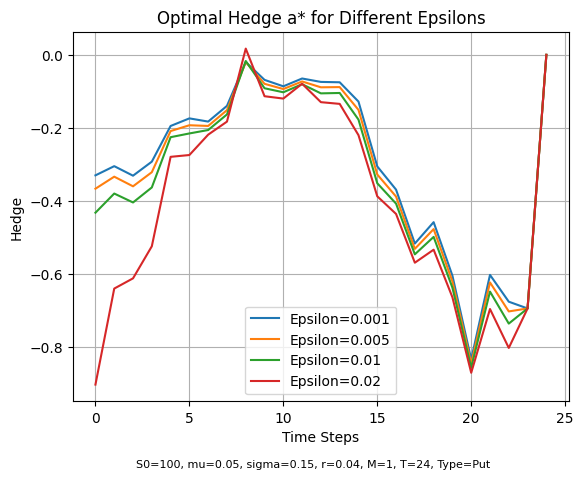

In [31]:
# Plot each epsilon key
for epsilon, series in a_results.items():
    plt.plot(series, label=f'Epsilon={epsilon}')

plt.xlabel('Time Steps')
plt.ylabel('Hedge')
plt.title('Optimal Hedge a* for Different Epsilons')
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.legend()
plt.grid(True)
plt.show()

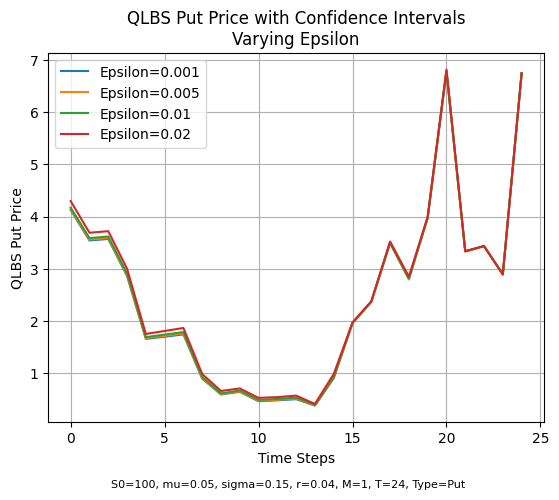

In [32]:
# Plot each epsilon key
for epsilon, q_values in q_results.items():
    plt.plot(-np.array(q_values), label=f'Epsilon={epsilon}')  # Negate q_values here

plt.xlabel('Time Steps')
plt.ylabel('QLBS Put Price')  # Change ylabel to QLBS Put Price
plt.title('QLBS Put Price with Confidence Intervals\nVarying Epsilon')  # Change title here
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.legend()
plt.grid(True)
plt.show()

## Vary Epsilon and Lambda

In [33]:
a_l_e_results = {0.001:[], 0.005:[], 0.01:[], 0.02:[]}
q_l_e_results = {0.001:[], 0.005:[], 0.01:[], 0.02:[]}

epsilons = [0.001, 0.005, 0.01, 0.02]
risk_lambdas = [0.0001, 0.001, 0.005, 0.01]

for epsilon in epsilons:
    for risk_lambda in risk_lambdas:
        a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon)
        R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)
        Q = compute_Q_function(Pi, data_mat_t, risk_lambda)

        # QLBS option price
        C_QLBS = - Q.copy()
        print('-------------------------------------------')
        print(f'Current Epsilon {epsilon} and risk aversion {risk_lambda}')
        print('%-26s %.4f' % (f'\nQLBS {opt_type} Price: ', C_QLBS.iloc[0,0]))
        print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
        print('-------------------------------------------')

        # append to results
        a_l_e_results[epsilon].append(a.iloc[0])
        q_l_e_results[epsilon].append(Q.iloc[0])

Computational time: 0.47895097732543945 seconds

Time Cost: 0.025476932525634766 seconds

Time Cost: 0.34537672996520996 seconds
-------------------------------------------
Current Epsilon 0.001 and risk aversion 0.0001

QLBS Put Price:           4.0326

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computational time: 0.4352531433105469 seconds

Time Cost: 0.025140047073364258 seconds

Time Cost: 0.3213081359863281 seconds
-------------------------------------------
Current Epsilon 0.001 and risk aversion 0.001

QLBS Put Price:           4.1257

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computational time: 0.4600839614868164 seconds

Time Cost: 0.025725841522216797 seconds

Time Cost: 0.4372420310974121 seconds
-------------------------------------------
Current Epsilon 0.001 and risk aversion 0.005

QLBS Put Price:           4.5398

Black-Sholes Put Price:   4.1075
-------------------------------------------
Computatio

Epsilon=0.001, Std Deviation: 0.2538
Epsilon=0.005, Std Deviation: 0.2666
Epsilon=0.01, Std Deviation: 0.2859
Epsilon=0.02, Std Deviation: 0.3527


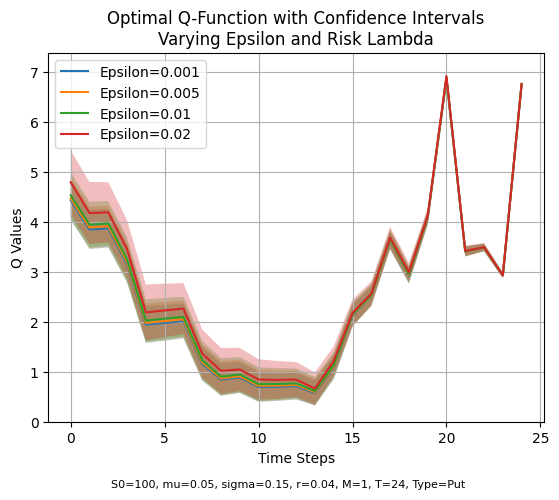

In [34]:
# Calculate mean and standard deviation for each time step
mean_q_values = {}
std_q_values = {}

for epsilon, q_values_list in q_l_e_results.items():
    q_values_array = np.array(q_values_list)
    mean_q_values[epsilon] = np.mean(q_values_array, axis=0)
    std_q_values[epsilon] = np.std(q_values_array, axis=0)

    # Print standard deviation for each epsilon
    print(f"Epsilon={epsilon}, Std Deviation: {np.mean(std_q_values[epsilon]):.4f}")

# Plot mean Q-values with confidence intervals
for epsilon, mean_q in mean_q_values.items():
    std_q = std_q_values[epsilon]
    upper_bound = mean_q + 1.96 * std_q / np.sqrt(len(q_l_e_results[epsilon]))
    lower_bound = mean_q - 1.96 * std_q / np.sqrt(len(q_l_e_results[epsilon]))

    plt.plot(-mean_q, label=f'Epsilon={epsilon}')
    plt.fill_between(range(len(mean_q)), -lower_bound, -upper_bound, alpha=0.3)

plt.xlabel('Time Steps')
plt.ylabel('Q Values')
plt.title('Optimal Q-Function with Confidence Intervals\nVarying Epsilon and Risk Lambda')
plt.suptitle('S0={}, mu={}, sigma={}, r={}, M={}, T={}, Type=Put'.format(S0, mu, sigma, r, M, T), fontsize=8, y=-0.01)
plt.legend()
plt.grid(True)
plt.show()

# QLBS Calculator

In [39]:
# User Inputs

## market dynamics
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.04      # risk-free rate

## option details
opt_type = 'Call'
M = 1         # maturity
K = 100       # option stike 
T = 24        # number of time steps
N_MC = 10000  # number of paths

## market dynamics
delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

np.random.seed(42)

risk_lambda = 0.0001 # risk-aversion
epsilon = 0.0 # transaction costs

# include transaction cost parameter epsilon
a, Pi, Pi_hat = calculate_optimal_hedge(N_MC, T, S, delta_S, delta_S_hat, data_mat_t, gamma, risk_lambda, epsilon)
R = compute_rewards(a, delta_S, Pi, gamma, risk_lambda)
Q = compute_Q_function(Pi, data_mat_t, risk_lambda)

# QLBS option price
C_QLBS = - Q.copy()

print('-------------------------------------------')
print(f'       QLBS {opt_type} Option Pricing (DP solution)      ')
print('-------------------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Trans Cost parameter: '), epsilon)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nQLBS Put Price: ', C_QLBS.iloc[0,0]))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
print('\n')

Computational time: 0.531160831451416 seconds

Time Cost: 0.026952028274536133 seconds

Time Cost: 0.3709559440612793 seconds
-------------------------------------------
       QLBS Call Option Pricing (DP solution)      
-------------------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.04
Risk aversion parameter:  0.0001
Trans Cost parameter:     0.0
Strike:                   100
Maturity:                 1

QLBS Put Price:           8.1138

Black-Sholes Put Price:   4.1075




# Part 3: Fitted Q-iteration (unknown price and reward dynamics)

Using the extension of Q-Learning to a batch RL setting called Fitted Q-Iteration.

Implement off-policy batch Q-Learning with Fitted-Q-Iteration. 

$N_{MC}$ paths for the underlying state variable $X_t$, hedge position $a_t$, instantaneous reward $R_t$ and the next-time value $X_{t+1}$.

$$\mathcal F_t^k=\left\{\left(X_t^k,a_t^k,R_t^k,X_{t+1}^k\right)\right\}_{t=0}^{T-1}\quad k=1,...,N_{MC}$$



## Under MC setting

### Perturb QLBS model-based hedges

In [27]:
def disturb_optimal_actions(a, risk_lambda, epsilon, eta=0.5):
    """
    Disturbs the optimal actions and computes corresponding portfolio values and rewards.

    Parameters:
    - a: DataFrame of optimal hedge values.
    - risk_lambda: Risk aversion coefficient.
    - epsilon: Transaction cost coefficient.
    - eta: Perturbation factor for disturbing optimal actions.

    Returns:
    - op_a: DataFrame of off-policy disturbed optimal hedge values.
    - op_Pi: DataFrame of off-policy disturbed portfolio values.
    - op_Pi_hat: DataFrame of off-policy disturbed portfolio values without mean.
    - op_R: DataFrame of off-policy disturbed rewards.
    """
    reg_param = 1e-3
    
    np.random.seed(42) # Fix random seed

    # Initialize off-policy disturbed optimal actions, portfolio values, and rewards
    op_a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    op_Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    op_Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    op_R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    
    # Initialize hedge at maturity
    op_a.iloc[:,-1] = 0

    # Initialize portfolio value at maturity
    op_Pi.iloc[:, -1] = S.iloc[:, -1].apply(lambda x: terminal_payoff(x, K, opt_type))
    op_Pi_hat.iloc[:,-1] = op_Pi.iloc[:,-1] - np.mean(op_Pi.iloc[:,-1])

    # Initialize reward at maturity
    op_R.iloc[:, -1] = - risk_lambda * np.var(op_Pi.iloc[:, -1])

    # Backward loop
    for t in range(T - 1, -1, -1):
        # Compute off-policy disturbed optimal actions by adding random noise
        op_a.loc[:, t] = a.loc[:, t] * np.random.uniform(1 - eta, 1 + eta, size=N_MC)

        # Compute off-policy disturbed portfolio values corresponding to observed actions with transaction cost adjustment
        op_Pi.loc[:, t] = gamma * (op_Pi.loc[:, t + 1] - op_a.loc[:, t] * delta_S.loc[:, t]) + epsilon * S.loc[:, t + 1] * abs(
            op_a.loc[:, t + 1] - op_a.loc[:, t])
        op_Pi_hat.loc[:,t] = op_Pi.loc[:,t] - np.mean(op_Pi.loc[:,t]) 
        
        # Compute off-policy disturbed rewards corresponding to observed actions
        op_R.loc[:, t] = gamma * op_a.loc[:, t] * delta_S.loc[:, t] - risk_lambda * np.var(
            op_Pi.loc[:, t])

    return op_a, op_Pi, op_Pi_hat, op_R


In [28]:
eta = 0.5 # pertubations
opt_type = 'Put'
risk_lambda = 0.001 # risk-aversion
epsilon = 0 # transaction costs

op_a, op_Pi, op_Pi_hat, op_R = disturb_optimal_actions(a, risk_lambda, epsilon, eta)

In [29]:
# Override on-policy data with off-policy data
a = op_a.copy()      # distrubed actions
Pi = op_Pi.copy()    # disturbed portfolio values
Pi_hat = op_Pi_hat.copy()
R = op_R.copy()

- Calculate $\mathbf S_t$ and $\mathbf M_t$ marix and vector
- Compute Vector $\vec W_t$, $$\vec W_t=\mathbf S_t^{-1}\mathbf M_t$$


In [30]:
def initialize_matrices(a, data_mat_t):
    num_MC = a.shape[0]  # number of simulated paths
    num_TS = a.shape[1]  # number of time steps

    # Calculate elements of A_t
    a_1_1 = a.values.reshape((1, num_MC, num_TS))
    a_1_2 = 0.5 * a_1_1 ** 2
    ones_3d = np.ones((1, num_MC, num_TS))
    A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

    # Swap axes of data_mat_t to match the shape of A_stack
    data_mat_swap_idx = np.swapaxes(data_mat_t, 0, 2)

    # Expand dimensions of matrices to multiply element-wise
    A_2 = np.expand_dims(A_stack, axis=1)
    data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)

    # Element-wise multiplication to obtain Psi_mat
    Psi_mat = np.multiply(A_2, data_mat_swap_idx)

    # Reshape Psi_mat
    Psi_mat = Psi_mat.reshape(-1, N_MC, T + 1, order='F')

    # Calculate S_t matrix
    Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
    Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
    S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2)

    return A_stack, S_t_mat, Psi_mat

In [31]:
A_stack, S_t_mat, Psi_mat = initialize_matrices(a, data_mat_t)

In [32]:
def compute_S_matrix(t, S_t_mat, reg_param):
    """
    Calculates the S matrix with regularization.

    Parameters:
    - t: Time index.
    - S_t_mat: 3D array of shape (num_Qbasis, num_Qbasis, T) containing S matrices.
    - reg_param: Regularization parameter.

    Returns:
    - S_mat_reg: S matrix with regularization applied.
    """
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:, :, t] + reg_param * np.eye(num_Qbasis)

    return S_mat_reg
   
def compute_M_vector(t, Q_star, R, Psi_mat_t, gamma=gamma):
    """
    Calculates the M vector.

    Parameters:
    - t: Time index.
    - Q_star: DataFrame of Q-function values of dimension N_MC x T.
    - R: DataFrame of rewards of dimension N_MC x T.
    - Psi_mat_t: DataFrame of dimension num_Qbasis x N_MC.
    - gamma: One time-step discount factor $exp(-r \delta t)$.

    Returns:
    - M_t: Array of dimension num_Qbasis x 1.
    """

    M_t = np.dot(Psi_mat_t, R.loc[:, t] + gamma * Q_star.loc[:, t + 1])

    return M_t


## Fitted Q Iteration (FQI)
- Calculate the matrix $ {\bf U}_t $
    at time $ t $ for the whole set of MC paths as follows (this is Eq.(65) from the paper in a matrix form):

    $$  \mathbf U_{W} \left(t,X_t \right) = 
    \left[\begin{matrix} \mathbf U_W^{0,k}\left(t,X_t \right) \\  
    \mathbf U_W^{1,k}\left(t,X_t \right) \\ \mathbf U_W^{2,k} \left(t,X_t \right)
    \end{matrix}\right]
    = \bf{W}_t \Phi_t \left(t,X_t \right)  $$


- The optimal action and optimal Q-function is computed by

$$a_t^\star\left(X_t\right)=\frac{\mathbb{E}_{t} \left[  \Delta \hat{S}_{t}  \hat{\Pi}_{t+1} + \frac{1}{2 \gamma \lambda} \Delta S_{t} \right]}{
  \mathbb{E}_{t} \left[ \left( \Delta \hat{S}_{t} \right)^2 \right]}\, , 
\quad\quad Q_t^\star\left(X_t,a_t^\star\right)=\mathbf U_W^{\left(0\right)}\left(t,X_t\right)+ a_t^\star \mathbf U_W^{\left(2\right)}\left(t,X_t\right) +\frac{1}{2}\left(a_t^\star\right)^2\mathbf U_W^{\left(2\right)}\left(t,X_t\right)$$

In [57]:
# Function to initialize dataframes for optimal actions and Q-functions
def initialize_dataframes(Pi, Q_RL):
    # Initialize arrays for optimal actions, optimal Q-function, and max Q-function
    a_opt = np.zeros((N_MC, T + 1))
    a_star = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    a_star.iloc[:, -1] = 0

    Q_star = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Q_star.iloc[:, -1] = Q_RL.iloc[:, -1]

    max_Q_star = np.zeros((N_MC, T + 1))
    max_Q_star[:, -1] = Q_RL.iloc[:, -1].values

    return a_opt, a_star, Q_star, max_Q_star


# Function to trim outliers in Q_RL dataframe
def trim_outliers(Q_RL, t, low_perc_Q_RL, up_perc_Q_RL):
    # Find outliers and replace them with percentiles
    flag_lower = Q_RL.loc[:, t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:, t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower, t] = low_perc_Q_RL
    Q_RL.loc[flag_upper, t] = up_perc_Q_RL
    return Q_RL


# Backward loop function
def backward_loop(delta_S_hat, data_mat_t, reg_param, Psi_mat, Pi_hat, risk_lambda):
    # Initialize Q_RL dataframe with terminal values
    Q_RL = pd.DataFrame(index=range(1, N_MC + 1), columns=range(T + 1))
    Q_RL.iloc[:, -1] = - Pi.iloc[:, -1] - risk_lambda * np.var(Pi.iloc[:, -1])

    # Initialize dataframes for optimal actions and Q-functions
    a_opt, a_star, Q_star, max_Q_star = initialize_dataframes(Pi, Q_RL)

    # Iterate backward in time
    for t in range(T - 1, -1, -1):
        # Compute S matrix and M vector
        S_mat_reg = compute_S_matrix(t, S_t_mat, reg_param)
        M_t = compute_M_vector(t, Q_star, R, Psi_mat[:, :, t], gamma)

        # Calculate weights W_t
        W_t = np.dot(np.linalg.inv(np.float64(S_mat_reg)), M_t)

        # Reshape weights to matrix form
        W_mat = W_t.reshape((3, num_basis), order='F')
        Phi_mat = data_mat_t[t, :, :].T
        U_mat = np.dot(W_mat, Phi_mat)

        # Calculate U vectors
        U_W_0 = U_mat[0, :]
        U_W_1 = U_mat[1, :]
        U_W_2 = U_mat[2, :]

        # Compute optimal actions
        A_mat = compute_A_vec(t, delta_S_hat, data_mat_t, reg_param)
        B_vec = compute_B_vec(t, Pi_hat, delta_S_hat, data_mat_t, gamma, risk_lambda)
        phi = np.dot(np.linalg.inv(A_mat), B_vec)
        a_opt[:, t] = np.dot(data_mat_t[t, :, :], phi)
        a_star.loc[:, t] = a_opt[:, t]

        # Compute max Q-function values
        max_Q_star[:, t] = U_W_0 + a_opt[:, t] * U_W_1 + 0.5 * (a_opt[:, t] ** 2) * U_W_2
        Q_star.loc[:, t] = max_Q_star[:, t]

        # Update Q_RL using dot product
        Psi_t = Psi_mat[:, :, t].T
        Q_RL.loc[:, t] = np.dot(Psi_t, W_t)

        # Trim outliers in Q_RL
        up_percentile_Q_RL = 95
        low_percentile_Q_RL = 5
        low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:, t], [low_percentile_Q_RL, up_percentile_Q_RL])
        Q_RL = trim_outliers(Q_RL, t, low_perc_Q_RL, up_perc_Q_RL)

    # Return optimal actions and Q-functions
    return a_star, Q_star


In [58]:
starttime = time.time()

a_star, Q_star = backward_loop(delta_S_hat, data_mat_t, reg_param, Psi_mat, Pi_hat, risk_lambda)

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 1.7947049140930176 seconds


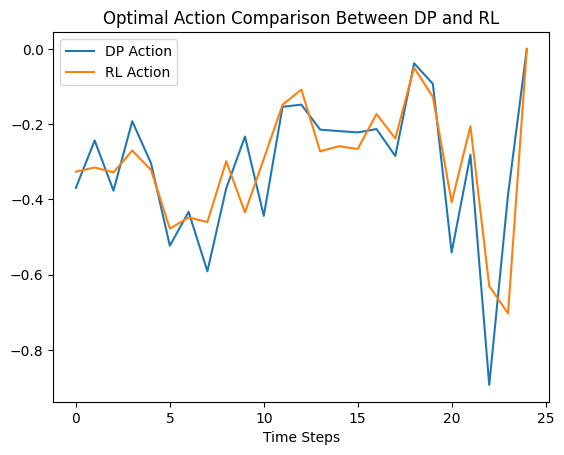

In [59]:
# plot a and a_star
# plot 1 path

num_path =  300  #120 #240 # 260 #  300 # 430 #  510

# Note that a from the DP method and a_star from the RL method are now identical by construction
plt.plot(a.T.iloc[:,num_path], label="DP Action")
plt.plot(a_star.T.iloc[:,num_path], label="RL Action")
plt.legend()
plt.xlabel('Time Steps')
plt.title('Optimal Action Comparison Between DP and RL')
plt.show()

In [60]:
# QLBS option price
C_QLBS = - Q_star.copy() # Q_RL # 

print('---------------------------------')
print('       QLBS RL Option Pricing       ')
print('---------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), M)
print('%-26s %.4f' % ('\nThe QLBS Put Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
print('%-26s %.4f' % ('\nBlack-Sholes Put Price:', bs_price(0)))
print('\n')

# # plot one path
# plt.plot(C_QLBS.T.iloc[:,[200]])
# plt.xlabel('Time Steps')
# plt.title('QLBS RL Option Price')
# plt.show()

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.04
Risk aversion parameter : 0.001
Strike:                   100
Maturity:                 1

The QLBS Put Price 1 :    4.6384

Black-Sholes Put Price:   4.1075


